In [606]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2

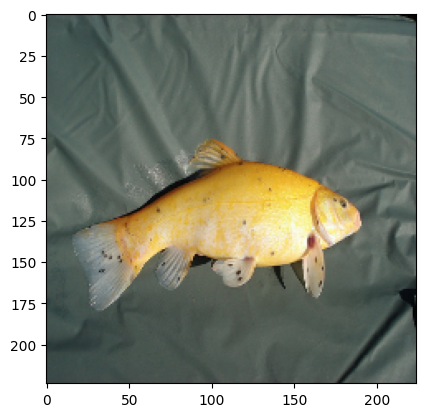

In [607]:
image = cv2.imread('../image.JPEG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image = torch.tensor(image/255., dtype=torch.float)
inp_x = torch.cat([image.unsqueeze(0), image.unsqueeze(0), image.unsqueeze(0)])
plt.imshow(image)

In [608]:
image_size = 224
patch_size = 16
n_channels = 3
d_model = 1024
dropout = 0.1
n_patches = int(image_size**2/patch_size**2) + 1
n_dim = (patch_size**2)*n_channels
n_heads = 64
n_x = 6
num_class = 10

In [609]:
class LinearProjection(nn.Module):
    def __init__(self, n_patches: int, patch_size: int, in_features: int, out_features: int, dropout: int) -> None:
        super().__init__()
        self.n_patches = n_patches - 1
        self.patch_size = patch_size
        self.linear_projection = nn.Linear(in_features, out_features)
        self.dropout = nn.Dropout(dropout)

    def patch_image(self, x):
        x = x.flatten(start_dim=1, end_dim=2)
        x = x.reshape((x.shape[0], self.n_patches, int(self.patch_size**2), 3))
        x = x.flatten(start_dim=-2, end_dim=-1)
        print(x.shape)
        return x

    def forward(self, x):
        x = self.patch_image(x)
        x = self.linear_projection(x)
        return self.dropout(x)

lp = LinearProjection(n_patches, patch_size, n_dim, d_model, dropout)
lp_x = lp(inp_x)
print(x.shape)

torch.Size([3, 196, 768])
torch.Size([3, 197, 1024])


In [610]:
class PositionalEmbedding(nn.Module):
    def __init__(self, n_patches: int, d_model: int, dropout: int) -> None:
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn((1, 1, d_model)))
        self.postion_embedding = nn.Parameter(torch.randn((1, n_patches, d_model)))
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        cls_token = self.cls_token.expand((x.shape[0], -1, -1))
        x = torch.cat([cls_token, x], dim=1)
        x = self.postion_embedding + x
        return self.dropout(x)
    
pe = PositionalEmbedding(n_patches, d_model, dropout)
x = pe(lp_x)
print(x.shape)

torch.Size([3, 197, 1024])


In [611]:
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, n_patches: int, d_model: int, n_heads: int, dropout: int) -> None:
        super().__init__()
        self.n_patches = n_patches
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model//n_heads
        self.layernorm = nn.LayerNorm((n_patches, d_model))
        self.dropout = nn.Dropout(dropout)
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.softmax = nn.Softmax(dim=-1)
        self.gelu = nn.GELU()

    def forward(self, x):
        residual_x = x
        x = self.layernorm(x)
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)
        q = q.reshape((q.shape[0], q.shape[1], self.n_heads, self.d_k)).transpose(1, 2)
        k = k.reshape((k.shape[0], k.shape[1], self.n_heads, self.d_k)).transpose(1, 2)
        v = v.reshape((v.shape[0], v.shape[1], self.n_heads, self.d_k)).transpose(1, 2)
        
        attention_scores = torch.matmul(q, k.transpose(-1, -2))/math.sqrt(self.d_k)
        attention_scores = self.softmax(attention_scores)
        x = torch.matmul(attention_scores, v)
        x = x.transpose(1, 2)
        x = x.reshape(x.shape[0], self.n_patches, self.d_model)
        x = self.w_o(x)
        x = residual_x + self.gelu(x)

        return self.dropout(x)

n_heads = 16
mha = MultiHeadAttention(n_patches, d_model, n_heads, dropout)
print(x.shape)
x = mha(x)
print(x.shape)

torch.Size([3, 197, 1024])
torch.Size([3, 197, 1024])


In [612]:
class MLPLayer(nn.Module):
    def __init__(self, seq_len: int, d_model: int, dropout: int) -> None:
        super().__init__()
        self.layernorm = nn.LayerNorm((seq_len, d_model))
        self.dropout = nn.Dropout(dropout)
        self.mlp = nn.Linear(d_model, d_model)
        self.gelu = nn.GELU()

    def forward(self, x):
        residual_x = x
        x = self.layernorm(x)
        x = self.mlp(x)
        x = residual_x + self.gelu(x)

        return self.dropout(x)
    
mlp = MLPLayer(seq_len, d_model, dropout)
x = mlp(x)
print(x.shape)

torch.Size([3, 197, 1024])


In [613]:
class EncoderBlock(nn.Module):
    def __init__(self, mha: MultiHeadAttention, mlp: MLPLayer, dropout: int) -> None:
        super().__init__()
        self.mha = mha
        self.mlp = mlp
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.mha(x)
        x = self.mlp(x)

        return self.dropout(x)
    
eb = EncoderBlock(mha, mlp, dropout)        
x = eb(x)
print(x.shape)

torch.Size([3, 197, 1024])


In [614]:
class Encoder(nn.Module):
    def __init__(self, n_x: int, seq_len: int, d_model: int, n_heads: int, dropout: int) -> None:
        super().__init__()
        self.encoder_blocks = nn.ModuleList()
        for i in range(n_x):
            mha = MultiHeadAttention(seq_len, d_model, n_heads, dropout)
            mlp = MLPLayer(seq_len, d_model, dropout)
            encoder = EncoderBlock(mha, mlp, dropout)
            self.encoder_blocks.append(encoder)

    def forward(self, x):
        for encoder in self.encoder_blocks:
            x = encoder(x)
        
        return x
    
n_x = 6
e = Encoder(n_x, seq_len, d_model, n_heads, dropout)
x = e(x)
print(x.shape)

torch.Size([3, 197, 1024])


In [615]:
class ClassificationHead(nn.Module):
    def __init__(self, num_class: int, d_model: int, dropout: int) -> None:
        super().__init__()
        self.mlp1 = nn.Linear(d_model, 4*d_model)
        self.mlp2 = nn.Linear(4*d_model, num_class)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = x[:, 0, :]
        x = self.mlp1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.mlp2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.softmax(x)

        return x
    
num_class = 10
mlph = ClassificationHead(num_class, d_model, dropout)
op = mlph(x)
print(op.shape)

torch.Size([3, 10])


In [616]:
class VisionTransformer(nn.Module):
    def __init__(self, patch_size: int, n_patches: int, linear_in_features:int, num_class: int, n_heads: int, d_model=1024, n_x=6, dropout=0.2) -> None:
        super().__init__()
        self.linear_projection = LinearProjection(n_patches, patch_size, linear_in_features, d_model, dropout)
        self.position_embedding = PositionalEmbedding(n_patches, d_model, dropout)
        self.encoder = Encoder(n_x, n_patches, d_model, n_heads, dropout)
        self.classifier = ClassificationHead(num_class, d_model, dropout)

    def forward(self, x):
        x = self.linear_projection(x)
        x = self.position_embedding(x)
        x = self.encoder(x)
        x = self.classifier(x)

        return x
    
vit = VisionTransformer(patch_size, n_patches, n_dim, num_class, n_heads, d_model, n_x, dropout)
op = vit(inp_x)
print(op.shape)

torch.Size([3, 196, 768])
torch.Size([3, 10])
